In [1]:
%matplotlib inline


# Matching Image Keypoints by Graph Matching Neural Networks

This example shows how to match image keypoints by neural network-based graph matching solvers.
These graph matching solvers are designed to match two individual graphs. The matched images
can be further passed to tackle downstream tasks.


In [2]:
# Author: Runzhong Wang <runzhong.wang@sjtu.edu.cn>
#
# License: Mulan PSL v2 License

<div class="alert alert-info"><h4>Note</h4><p>The following solvers are based on matching two individual graphs, and are included in this example:

    * :func:`~pygmtools.neural_solvers.pca_gm` (neural network solver)

    * :func:`~pygmtools.neural_solvers.ipca_gm` (neural network solver)

    * :func:`~pygmtools.neural_solvers.cie` (neural network solver)</p></div>




In [3]:
import torch # pytorch backend
import torchvision # CV models
import pygmtools as pygm
import matplotlib.pyplot as plt # for plotting
from matplotlib.patches import ConnectionPatch # for plotting matching result
import scipy.io as sio # for loading .mat file
import scipy.spatial as spa # for Delaunay triangulation
from sklearn.decomposition import PCA as PCAdimReduc
import itertools
import numpy as np
from PIL import Image
pygm.BACKEND = 'pytorch' # set default backend for pygmtools

## Predicting Matching by Graph Matching Neural Networks
In this section we show how to do predictions (inference) by graph matching neural networks.
Let's take PCA-GM (:func:`~pygmtools.neural_solvers.pca_gm`) as an example.

### Load the images
Images are from the Willow Object Class dataset (this dataset also available with the Benchmark of ``pygmtools``,
see :class:`~pygmtools.dataset.WillowObject`).

The images are resized to 256x256.




In [4]:
obj_resize = (256, 256)
img1 = Image.open('../Data/WillowObjectToy/willow_duck_0001.png')
img2 = Image.open('../Data/WillowObjectToy/willow_duck_0002.png')
kpts1 = torch.tensor(sio.loadmat('../Data/WillowObjectToy/willow_duck_0001.mat')['pts_coord'])
kpts2 = torch.tensor(sio.loadmat('../Data/WillowObjectToy/willow_duck_0002.mat')['pts_coord'])
kpts1[0] = kpts1[0] * obj_resize[0] / img1.size[0]
kpts1[1] = kpts1[1] * obj_resize[1] / img1.size[1]
kpts2[0] = kpts2[0] * obj_resize[0] / img2.size[0]
kpts2[1] = kpts2[1] * obj_resize[1] / img2.size[1]
img1 = img1.resize(obj_resize, resample=Image.BILINEAR)
img2 = img2.resize(obj_resize, resample=Image.BILINEAR)
torch_img1 = torch.from_numpy(np.array(img1, dtype=np.float32) / 256).permute(2, 0, 1).unsqueeze(0) # shape: BxCxHxW
torch_img2 = torch.from_numpy(np.array(img2, dtype=np.float32) / 256).permute(2, 0, 1).unsqueeze(0) # shape: BxCxHxW

Visualize the images and keypoints




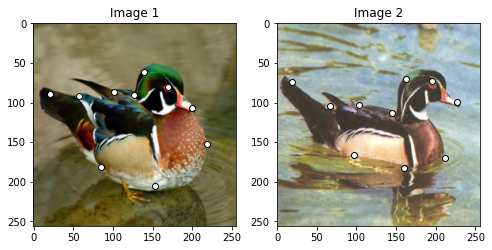

In [5]:
def plot_image_with_graph(img, kpt, A=None):
    plt.imshow(img)
    plt.scatter(kpt[0], kpt[1], c='w', edgecolors='k')
    if A is not None:
        for idx in torch.nonzero(A, as_tuple=False):
            plt.plot((kpt[0, idx[0]], kpt[0, idx[1]]), (kpt[1, idx[0]], kpt[1, idx[1]]), 'k-')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plot_image_with_graph(img1, kpts1)
plt.subplot(1, 2, 2)
plt.title('Image 2')
plot_image_with_graph(img2, kpts2)

### Build the graphs
Graph structures are built based on the geometric structure of the keypoint set. In this example,
we refer to [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).




In [6]:
def delaunay_triangulation(kpt):
    d = spa.Delaunay(kpt.numpy().transpose())
    A = torch.zeros(len(kpt[0]), len(kpt[0]))
    for simplex in d.simplices:
        for pair in itertools.permutations(simplex, 2):
            A[pair] = 1
    return A

A1 = delaunay_triangulation(kpts1)
A2 = delaunay_triangulation(kpts2)

Visualize the graphs




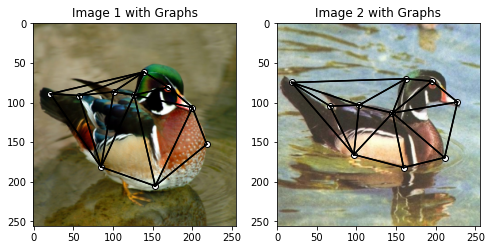

In [7]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with Graphs')
plot_image_with_graph(img1, kpts1, A1)
plt.subplot(1, 2, 2)
plt.title('Image 2 with Graphs')
plot_image_with_graph(img2, kpts2, A2)

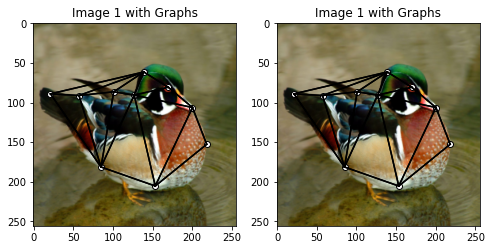

In [41]:
perm_idx = torch.randperm(10)
kpts1_perm = (kpts1.T[perm_idx]).T
A1_perm = delaunay_triangulation(kpts1_perm)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with Graphs')
plot_image_with_graph(img1, kpts1, A1)
plt.subplot(1, 2, 2)
plt.title('Image 1 with Graphs')
plot_image_with_graph(img1, kpts1_perm, A1_perm)

### Extract node features via CNN
Deep graph matching solvers can be fused with CNN feature extractors, to build an end-to-end learning pipeline.

In this example, let's adopt the deep graph solvers based on matching two individual graphs.
The image features are based on two intermediate layers from the VGG16 CNN model, following
existing deep graph matching papers (such as :func:`~pygmtools.neural_solvers.pca_gm`)

Let's firstly fetch and download the VGG16 model:




In [8]:
vgg16_cnn = torchvision.models.vgg16_bn(True)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


List of layers of VGG16:




In [9]:
print(vgg16_cnn.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Let's define the CNN feature extractor, which outputs the features of ``layer (30)`` and
``layer (37)``




In [10]:
class CNNNet(torch.nn.Module):
    def __init__(self, vgg16_module):
        super(CNNNet, self).__init__()
        # The naming of the layers follow ThinkMatch convention to load pretrained models.
        self.node_layers = torch.nn.Sequential(*[_ for _ in vgg16_module.features[:31]])
        self.edge_layers = torch.nn.Sequential(*[_ for _ in vgg16_module.features[31:38]])

    def forward(self, inp_img):
        feat_local = self.node_layers(inp_img)
        feat_global = self.edge_layers(feat_local)
        return feat_local, feat_global

Download pretrained CNN weights (from [ThinkMatch](https://github.com/Thinklab-SJTU/ThinkMatch)),
load the weights and then extract the CNN features




In [11]:
cnn = CNNNet(vgg16_cnn)
path = pygm.utils.download('vgg16_pca_voc_pytorch.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1JnX3cSPvRYBSrDKVwByzp7CADgVCJCO_')
if torch.cuda.is_available():
    map_location = torch.device('cuda:0')
else:
    map_location = torch.device('cpu')
cnn.load_state_dict(torch.load(path, map_location=map_location), strict=False)
with torch.set_grad_enabled(False):
    feat1_local, feat1_global = cnn(torch_img1)
    feat2_local, feat2_global = cnn(torch_img2)

Normalize the features




In [12]:
def l2norm(node_feat):
    return torch.nn.functional.local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

Up-sample the features to the original image size and concatenate




In [13]:
feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

Visualize the extracted CNN feature (dimensionality reduction via principle component analysis)




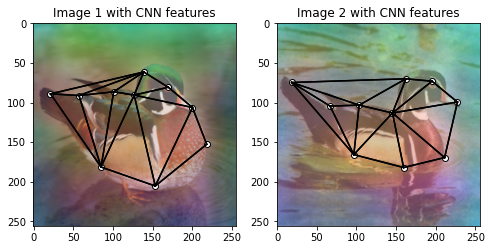

In [14]:
pca_dim_reduc = PCAdimReduc(n_components=3, whiten=True)
feat_dim_reduc = pca_dim_reduc.fit_transform(
    np.concatenate((
        feat1_upsample.permute(0, 2, 3, 1).reshape(-1, num_features).numpy(),
        feat2_upsample.permute(0, 2, 3, 1).reshape(-1, num_features).numpy()
    ), axis=0)
)
feat_dim_reduc = feat_dim_reduc / np.max(np.abs(feat_dim_reduc), axis=0, keepdims=True) / 2 + 0.5
feat1_dim_reduc = feat_dim_reduc[:obj_resize[0] * obj_resize[1], :]
feat2_dim_reduc = feat_dim_reduc[obj_resize[0] * obj_resize[1]:, :]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with CNN features')
plot_image_with_graph(img1, kpts1, A1)
plt.imshow(feat1_dim_reduc.reshape(obj_resize[0], obj_resize[1], 3), alpha=0.5)
plt.subplot(1, 2, 2)
plt.title('Image 2 with CNN features')
plot_image_with_graph(img2, kpts2, A2)
plt.imshow(feat2_dim_reduc.reshape(obj_resize[0], obj_resize[1], 3), alpha=0.5)

Extract node features by nearest interpolation




In [15]:
rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

### Call PCA-GM matching model
See :func:`~pygmtools.neural_solvers.pca_gm` for the API reference.




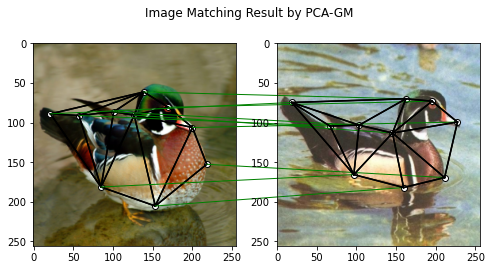

In [16]:
X = pygm.pca_gm(node1, node2, A1, A2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by PCA-GM')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

## Matching images with other neural networks
The above pipeline also works for other deep graph matching networks. Here we give examples of
:func:`~pygmtoools.neural_solvers.ipca_gm` and :func:`~pygmtoools.neural_solvers.cie`.

### Matching by IPCA-GM model
See :func:`~pygmtools.neural_solvers.ipca_gm` for the API reference.




In [17]:
path = pygm.utils.download('vgg16_ipca_voc_pytorch.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1TGrbSQRmUkClH3Alz2OCwqjl8r8gf5yI')
cnn.load_state_dict(torch.load(path, map_location=map_location), strict=False)

with torch.set_grad_enabled(False):
    feat1_local, feat1_global = cnn(torch_img1)
    feat2_local, feat2_global = cnn(torch_img2)

Normalize the features




In [18]:
def l2norm(node_feat):
    return torch.nn.functional.local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

Up-sample the features to the original image size and concatenate




In [19]:
feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

Extract node features by nearest interpolation




In [20]:
rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

Build edge features as edge lengths




In [21]:
kpts1_dis = (kpts1.unsqueeze(0) - kpts1.unsqueeze(1))
kpts1_dis = torch.norm(kpts1_dis, p=2, dim=2).detach()
kpts2_dis = (kpts2.unsqueeze(0) - kpts2.unsqueeze(1))
kpts2_dis = torch.norm(kpts2_dis, p=2, dim=2).detach()

Q1 = torch.exp(-kpts1_dis / obj_resize[0])
Q2 = torch.exp(-kpts2_dis / obj_resize[0])

Matching by IPCA-GM model




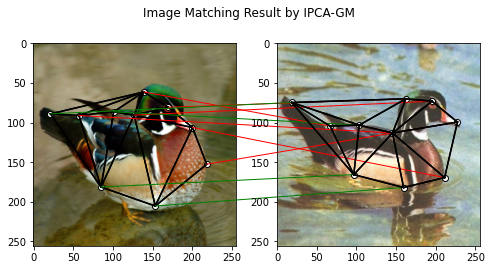

In [22]:
X = pygm.ipca_gm(node1, node2, A1, A2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by IPCA-GM')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

### Matching by CIE model
See :func:`~pygmtools.neural_solvers.cie` for the API reference.




In [23]:
path = pygm.utils.download('vgg16_cie_voc_pytorch.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1oRwcnw06t1rCbrIN_7p8TJZY-XkBOFEp')
cnn.load_state_dict(torch.load(path, map_location=map_location), strict=False)

with torch.set_grad_enabled(False):
    feat1_local, feat1_global = cnn(torch_img1)
    feat2_local, feat2_global = cnn(torch_img2)

Normalize the features




In [24]:
def l2norm(node_feat):
    return torch.nn.functional.local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

Up-sample the features to the original image size and concatenate




In [25]:
feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

Extract node features by nearest interpolation




In [26]:
rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

Build edge features as edge lengths




In [27]:
kpts1_dis = (kpts1.unsqueeze(1) - kpts1.unsqueeze(2))
kpts1_dis = torch.norm(kpts1_dis, p=2, dim=0).detach()
kpts2_dis = (kpts2.unsqueeze(1) - kpts2.unsqueeze(2))
kpts2_dis = torch.norm(kpts2_dis, p=2, dim=0).detach()

Q1 = torch.exp(-kpts1_dis / obj_resize[0]).unsqueeze(-1).to(dtype=torch.float32)
Q2 = torch.exp(-kpts2_dis / obj_resize[0]).unsqueeze(-1).to(dtype=torch.float32)

Call CIE matching model




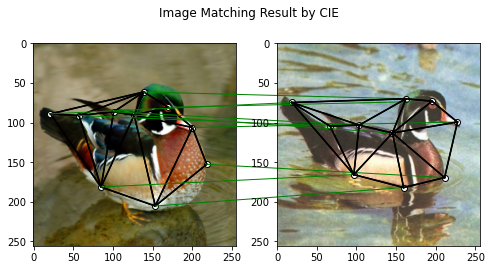

In [28]:
X = pygm.cie(node1, node2, A1, A2, Q1, Q2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by CIE')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

## Training a deep graph matching model
In this section, we show how to build a deep graph matching model which supports end-to-end training.
For the image matching problem considered here, the model is composed of a CNN feature extractor and
a learnable matching module. Take the PCA-GM model as an example.

<div class="alert alert-info"><h4>Note</h4><p>This simple example is intended to show you how to do the basic forward and backward pass when
    training an end-to-end deep graph matching neural network. A 'more formal' deep learning pipeline
    should involve asynchronized data loader, batched operations, CUDA support and so on, which are
    all omitted in consideration of simplicity. You may refer to [ThinkMatch](https://github.com/Thinklab-SJTU/ThinkMatch)
    which is a research protocol with all these advanced features.</p></div>

Let's firstly define the neural network model. By passing ``None`` to :func:`~pygmtools.neural_solvers.pca_gm`,
it will simply return the network object.




In [29]:
class GMNet(torch.nn.Module):
    def __init__(self):
        super(GMNet, self).__init__()
        self.gm_net = pygm.utils.get_network(pygm.pca_gm, pretrain=False) # fetch the network object
        self.cnn = CNNNet(vgg16_cnn)

    def forward(self, img1, img2, kpts1, kpts2, A1, A2):
        # CNN feature extractor layers
        feat1_local, feat1_global = self.cnn(img1)
        feat2_local, feat2_global = self.cnn(img2)
        feat1_local = l2norm(feat1_local)
        feat1_global = l2norm(feat1_global)
        feat2_local = l2norm(feat2_local)
        feat2_global = l2norm(feat2_global)

        # upsample feature map
        feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
        feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
        feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
        feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
        feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
        feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)

        # assign node features
        rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
        rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
        node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t()  # shape: NxC
        node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t()  # shape: NxC

        # PCA-GM matching layers
        X = pygm.pca_gm(node1, node2, A1, A2, network=self.gm_net) # the network object is reused
        return X

model = GMNet()

### Define optimizer




In [30]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

### Forward pass




In [31]:
X = model(torch_img1, torch_img2, kpts1, kpts2, A1, A2)

### Compute loss
In this example, the ground truth matching matrix is a diagonal matrix. We calculate the loss function via
:func:`~pygmtools.utils.permutation_loss`




In [32]:
X_gt = torch.eye(X.shape[0])
loss = pygm.utils.permutation_loss(X, X_gt)
print(f'loss={loss:.4f}')

loss=3.0112


### Backward Pass




In [33]:
loss.backward()

Visualize the gradients




[0.00011890891619259492, 0.0027671167626976967, 0.0001838760799728334, 0.0032772060949355364, 0.00020601978758350015, 0.005192530807107687, 1.5425017409143038e-05, 4.620563049684279e-05, 9.59905592026189e-05, 0.0037848844658583403, 0.00012945150956511497, 0.00292799505405128, 0.00044299536966718733, 1.0436890462983683e-08, 0.0009249442955479026, 0.0006093739066272974, 0.00015612381685059518, 4.284859578262967e-09, 0.0021737245842814445, 0.001202496001496911, 0.00020824918465223163, 2.1035473363184565e-09, 0.0014491601614281535, 0.0010586322750896215, 0.00018339189409743994, 2.7739339714116795e-09, 0.0017148450715467334, 0.0010221786797046661, 0.00017776602180674672, 9.394246491822855e-10, 0.0014072117628529668, 0.001141090295277536, 0.00015231856377795339, 1.367708168942272e-09, 0.0017080908874049783, 0.001244839048013091, 0.00016626555589027703, 1.7105270533335215e-09, 0.001718955929391086, 0.0009601037600077689, 0.00015150585386436433, 4.920692742160782e-10, 0.001588954241015017, 0.0

<StemContainer object of 3 artists>

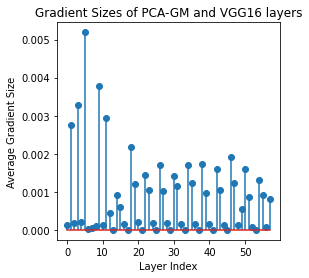

In [34]:
plt.figure(figsize=(4, 4))
plt.title('Gradient Sizes of PCA-GM and VGG16 layers')
plt.gca().set_xlabel('Layer Index')
plt.gca().set_ylabel('Average Gradient Size')
grad_size = []
for param in model.parameters():
    grad_size.append(torch.abs(param.grad).mean().item())
print(grad_size)
plt.stem(grad_size)

Update the model parameters. A deep learning pipeline should iterate the forward pass
and backward pass steps until convergence.




In [35]:
optim.step()
optim.zero_grad()

<div class="alert alert-info"><h4>Note</h4><p>This example supports both GPU and CPU, and the online documentation is built by a CPU-only machine.
    The efficiency will be significantly improved if you run this code on GPU.</p></div>


